# Cellular automata as convolutional neural networks

This notebook is based on the following paper and code:

> Gilpin, William. *Cellular Automata as Convolutional Neural Networks*. Phys. Rev. E 100 (September 2019): 032402. DOI: 10.1103/PhysRevE.100.032402
> [https://github.com/williamgilpin/convoca](https://github.com/williamgilpin/convoca)

## Setup

Required packages:

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from matplotlib.animation import FuncAnimation
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

from ca_funcs import make_glider, make_game_of_life
from utils import *
from train_ca import *

plt.rcParams['figure.dpi'] = 300
sys.path.insert(0, '..')

/Users/mwojnar/main-venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Helper functions:

In [2]:
gol = make_game_of_life()


def play_game(init_state, steps):
    states = [tf.cast(init_state, tf.float32)]
    
    for i in range(steps):
        states.append(gol(states[-1])[None, ...])
        
    return states


def play_game_with_model(init_state, model, steps):
    states = [tf.cast(init_state, tf.float32)]
    
    for i in range(steps):
        next_state = model(states[-1]) > 0.5
        next_state = tf.cast(next_state, tf.float32)
        states.append(next_state.numpy())
        
    return states


def plot_states(states, title, filename):
    
    def create_frame(i):
        plt.clf()
        plt.imshow(1 - states[i][0], cmap='gray')
        plt.axis('off')
        plt.title(title)
        plt.tight_layout()
        return []
    
    fig, _ = plt.subplots()
    animation = FuncAnimation(fig, create_frame, frames=len(states), interval=125, repeat=True)
    animation.save(filename, writer='Pillow', fps=8)

    with open(filename, 'rb') as img:
        display(Image(data=img.read(), format='png'))

# Cellular automata

A cellular automata is a discrete computational model consisting of a grid of cells, each in one of a finite number of states. These cells evolve through a series of discrete time steps based on a set of predefined rules, determined by the states of neighboring cells. The system's state at any given time is a function of its initial state and the applied rules.

### Game of Life

- Any live cell with fewer than two live neighbours dies, as if by underpopulation.
- Any live cell with two or three live neighbours lives on to the next generation.
- Any live cell with more than three live neighbours dies, as if by overpopulation.
- Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

MovieWriter Pillow unavailable; using Pillow instead.


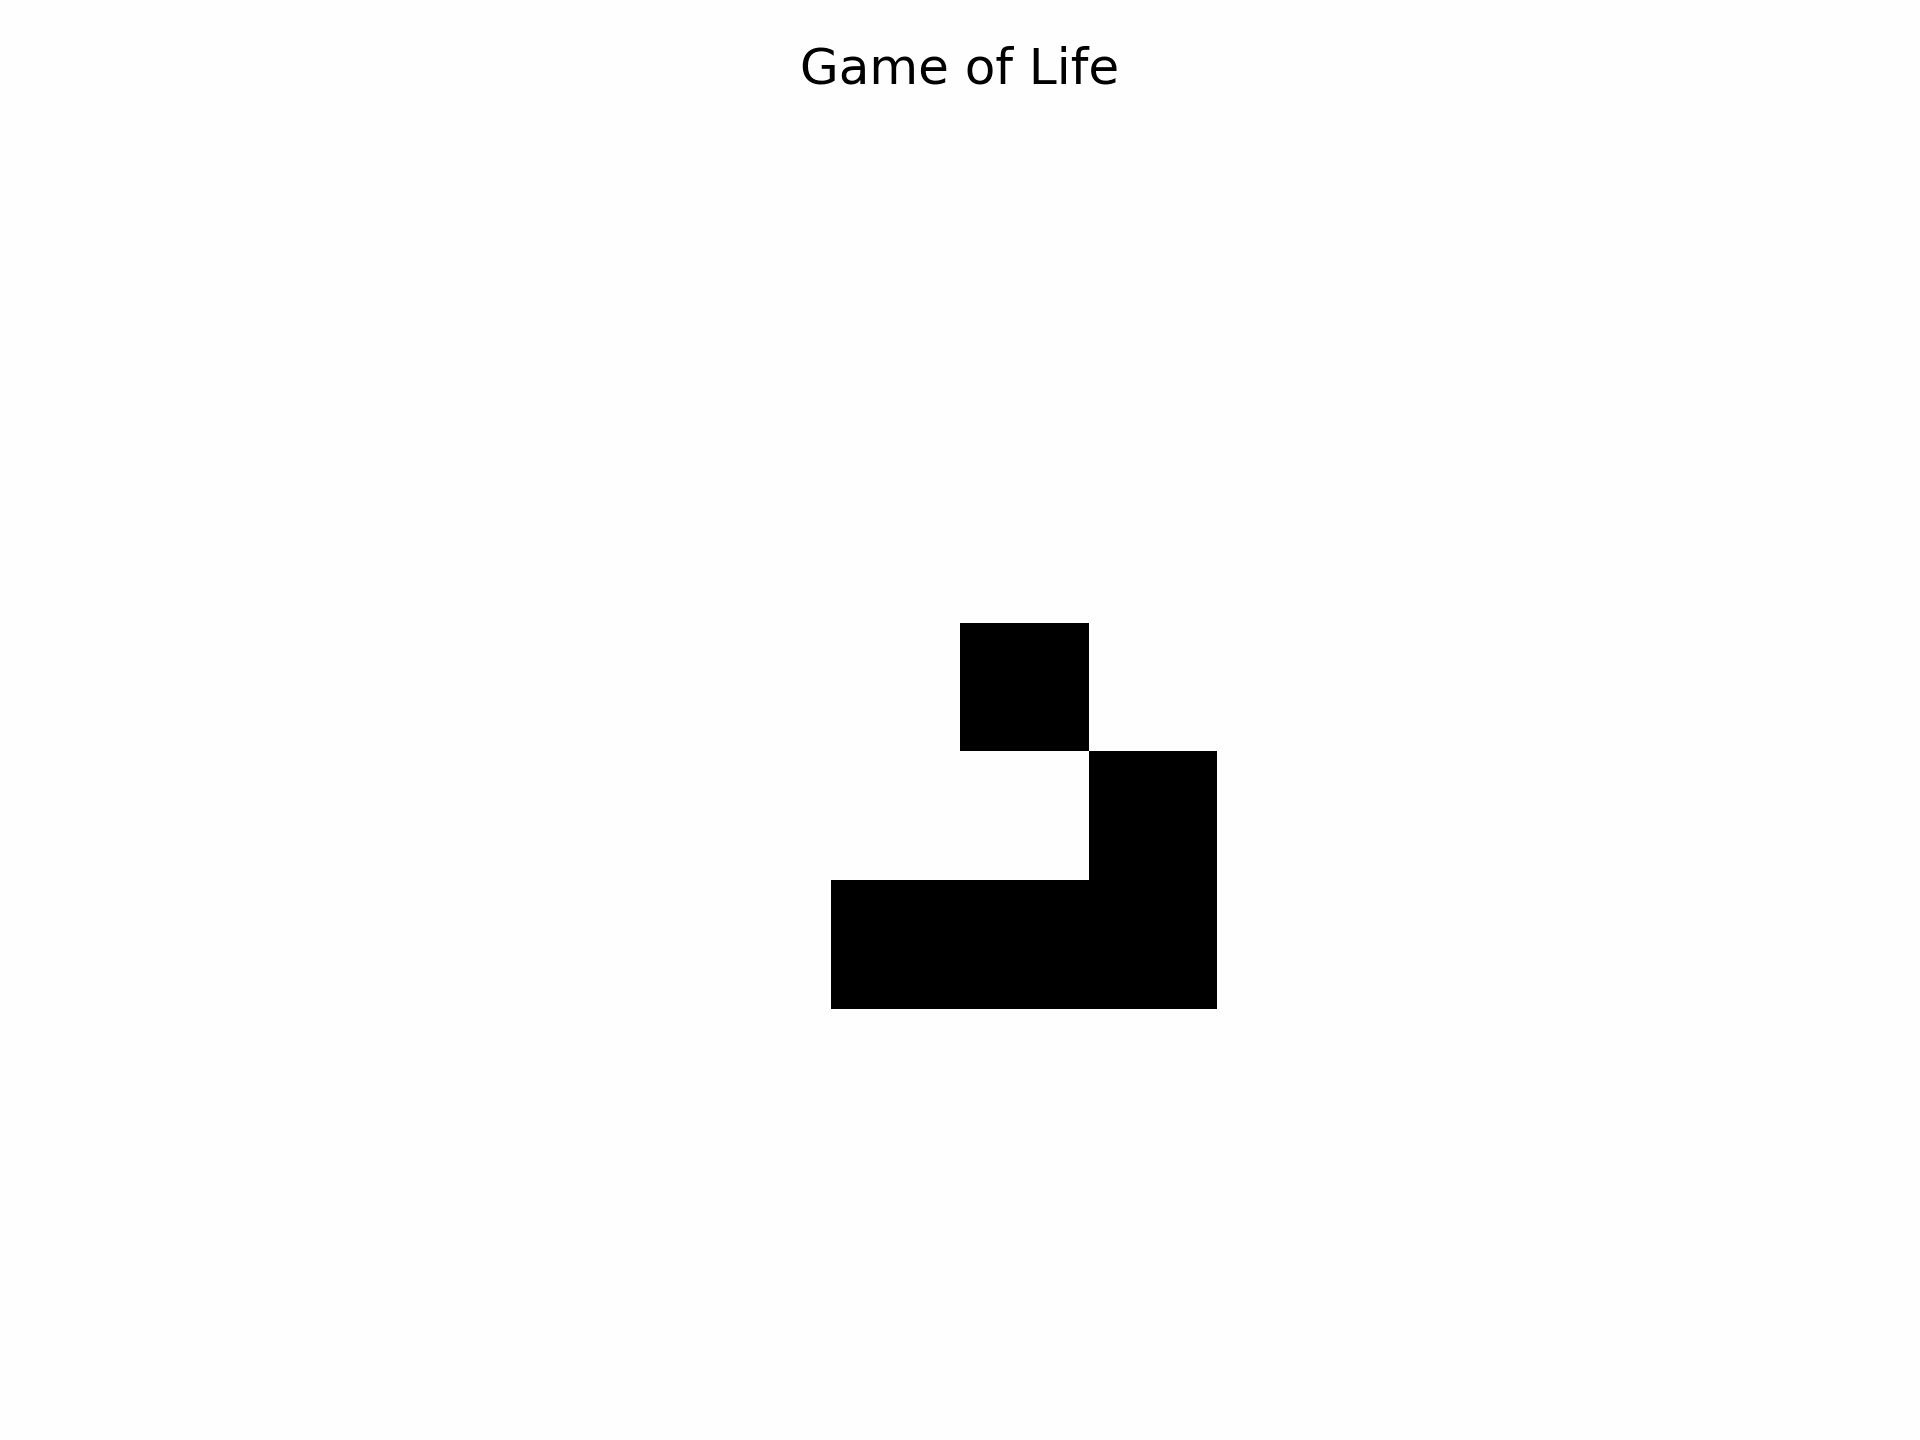

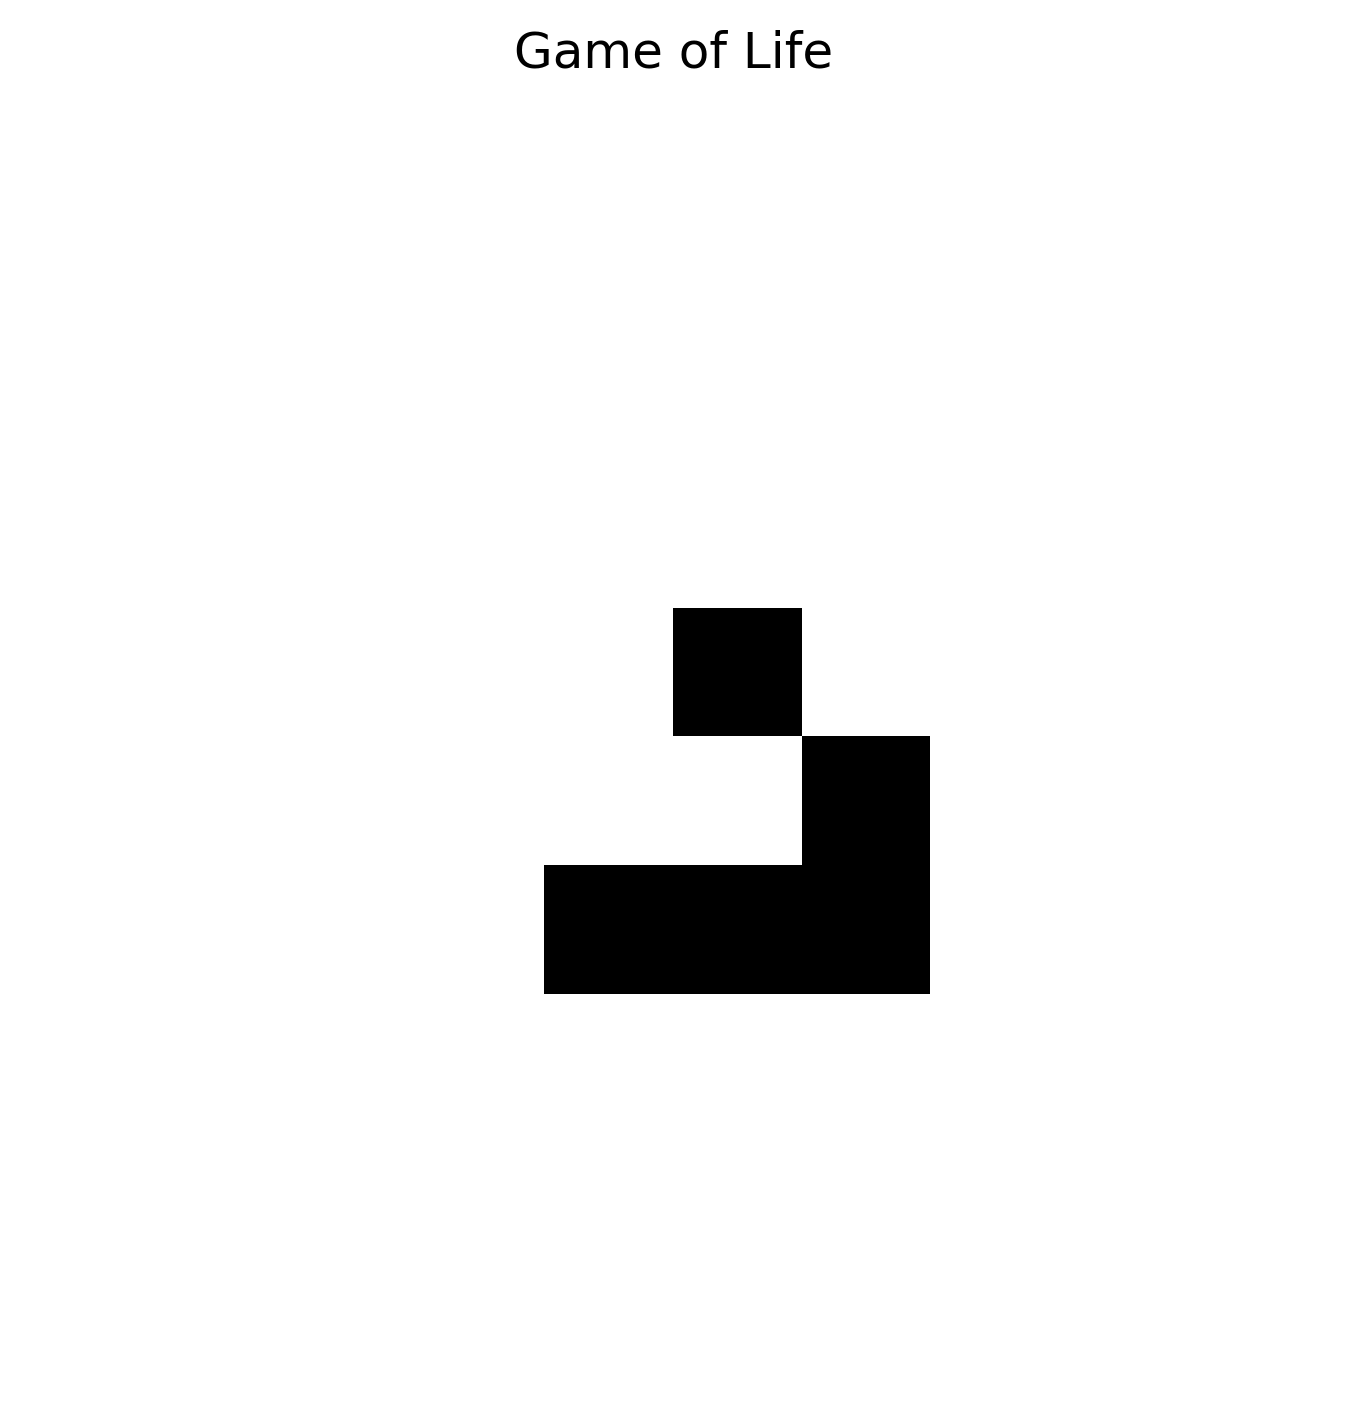

In [3]:
init_state = make_glider(dims0=10)[None, ...]
states = play_game(init_state, 40)
plot_states(states, 'Game of Life', 'images/gol.gif')

## Convolutional neural network

"Conway’s Game of Life as a convolutional neural network. Two convolutional filters identify the value of the center pixel and
count the number of neighbors. These features are then scored and summed to generate a prediction for the system at the next timestep."

### Architecture and parameters

![Architecture of the convolutional neural network](images/architecture.png)
![Parameters](images/parameters.png)

### Training

In [4]:
BOARD_SIZE = 10
N_SAMPLES = 500
NUM_CLASSES = 2

X_train = tf.random.categorical(tf.math.log([[0.5, 0.5]]), N_SAMPLES * BOARD_SIZE * BOARD_SIZE)
X_train = tf.cast(X_train, tf.float32)
X_train = tf.reshape(X_train, (N_SAMPLES, BOARD_SIZE, BOARD_SIZE))

Y_train = gol(X_train)

In [5]:
LAYER_DIMS = 12 * [100]
LEARNING_RATE = 1e-4

model = initialize_model((BOARD_SIZE, BOARD_SIZE), LAYER_DIMS, num_classes=1)
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), 
    loss=tf.keras.losses.MeanSquaredError()
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wraparound2d (Wraparound2D  (None, 12, 12, 1)         0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 10, 10, 100)       1000      
                                                                 
 reshape (Reshape)           (None, 100, 100)          0         
                                                                 
 dense (Dense)               (None, 100, 100)          10100     
                                                                 
 dense_1 (Dense)             (None, 100, 100)          10100     
                                                                 
 dense_2 (Dense)             (None, 100, 100)          10100     
                                                        

In [6]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=10)

Epoch 1/100


2023-10-07 18:16:07.368760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


50/50 [==============================] - 5s 12ms/step - loss: 0.1706
Epoch 2/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0694
Epoch 3/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0234
Epoch 4/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0049
Epoch 5/100
50/50 [==============================] - 1s 11ms/step - loss: 6.0426e-04
Epoch 6/100
50/50 [==============================] - 1s 11ms/step - loss: 5.1937e-05
Epoch 7/100
50/50 [==============================] - 1s 11ms/step - loss: 3.4722e-06
Epoch 8/100
50/50 [==============================] - 1s 11ms/step - loss: 9.8043e-08
Epoch 9/100
50/50 [==============================] - 1s 11ms/step - loss: 1.6341e-09
Epoch 10/100
50/50 [==============================] - 1s 11ms/step - loss: 2.1454e-11
Epoch 11/100
50/50 [==============================] - 1s 11ms/step - loss: 2.0534e-12
Epoch 12/100
50/50 [==============================] - 1s 11ms/step - loss: 1.0150e-12
Epoch

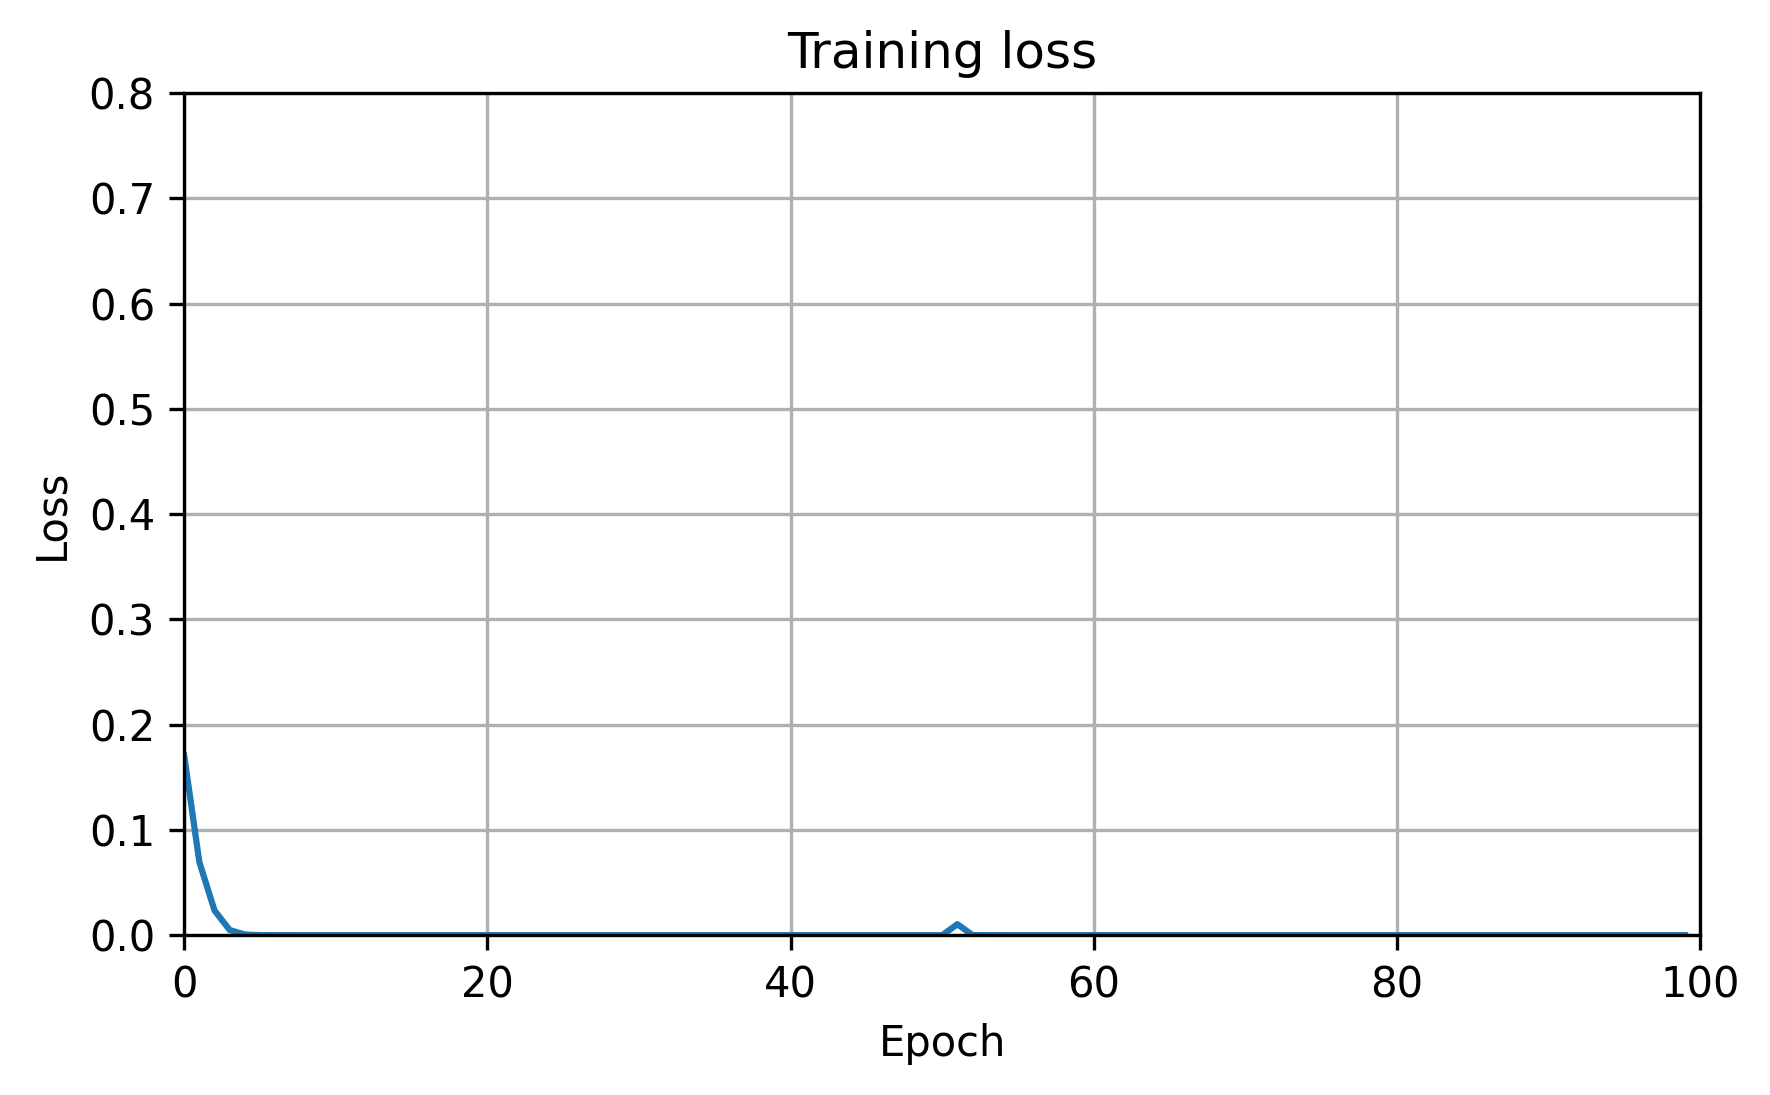

In [7]:
fig, ax = plt.subplots(figsize=(6, 6 / 1.6))

ax.plot(history.history['loss'])
ax.set_xlim(0, len(history.history['loss']))
ax.set_ylim(0, 0.8)

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training loss')

ax.grid()
plt.tight_layout()

plt.savefig('images/loss.png', dpi=300)
plt.show()

In [ ]:
model.save('models/model.keras')
# model = tf.keras.models.load_model('models/model.keras', custom_objects={'Wraparound2D': Wraparound2D}, safe_mode=False)

### Demo

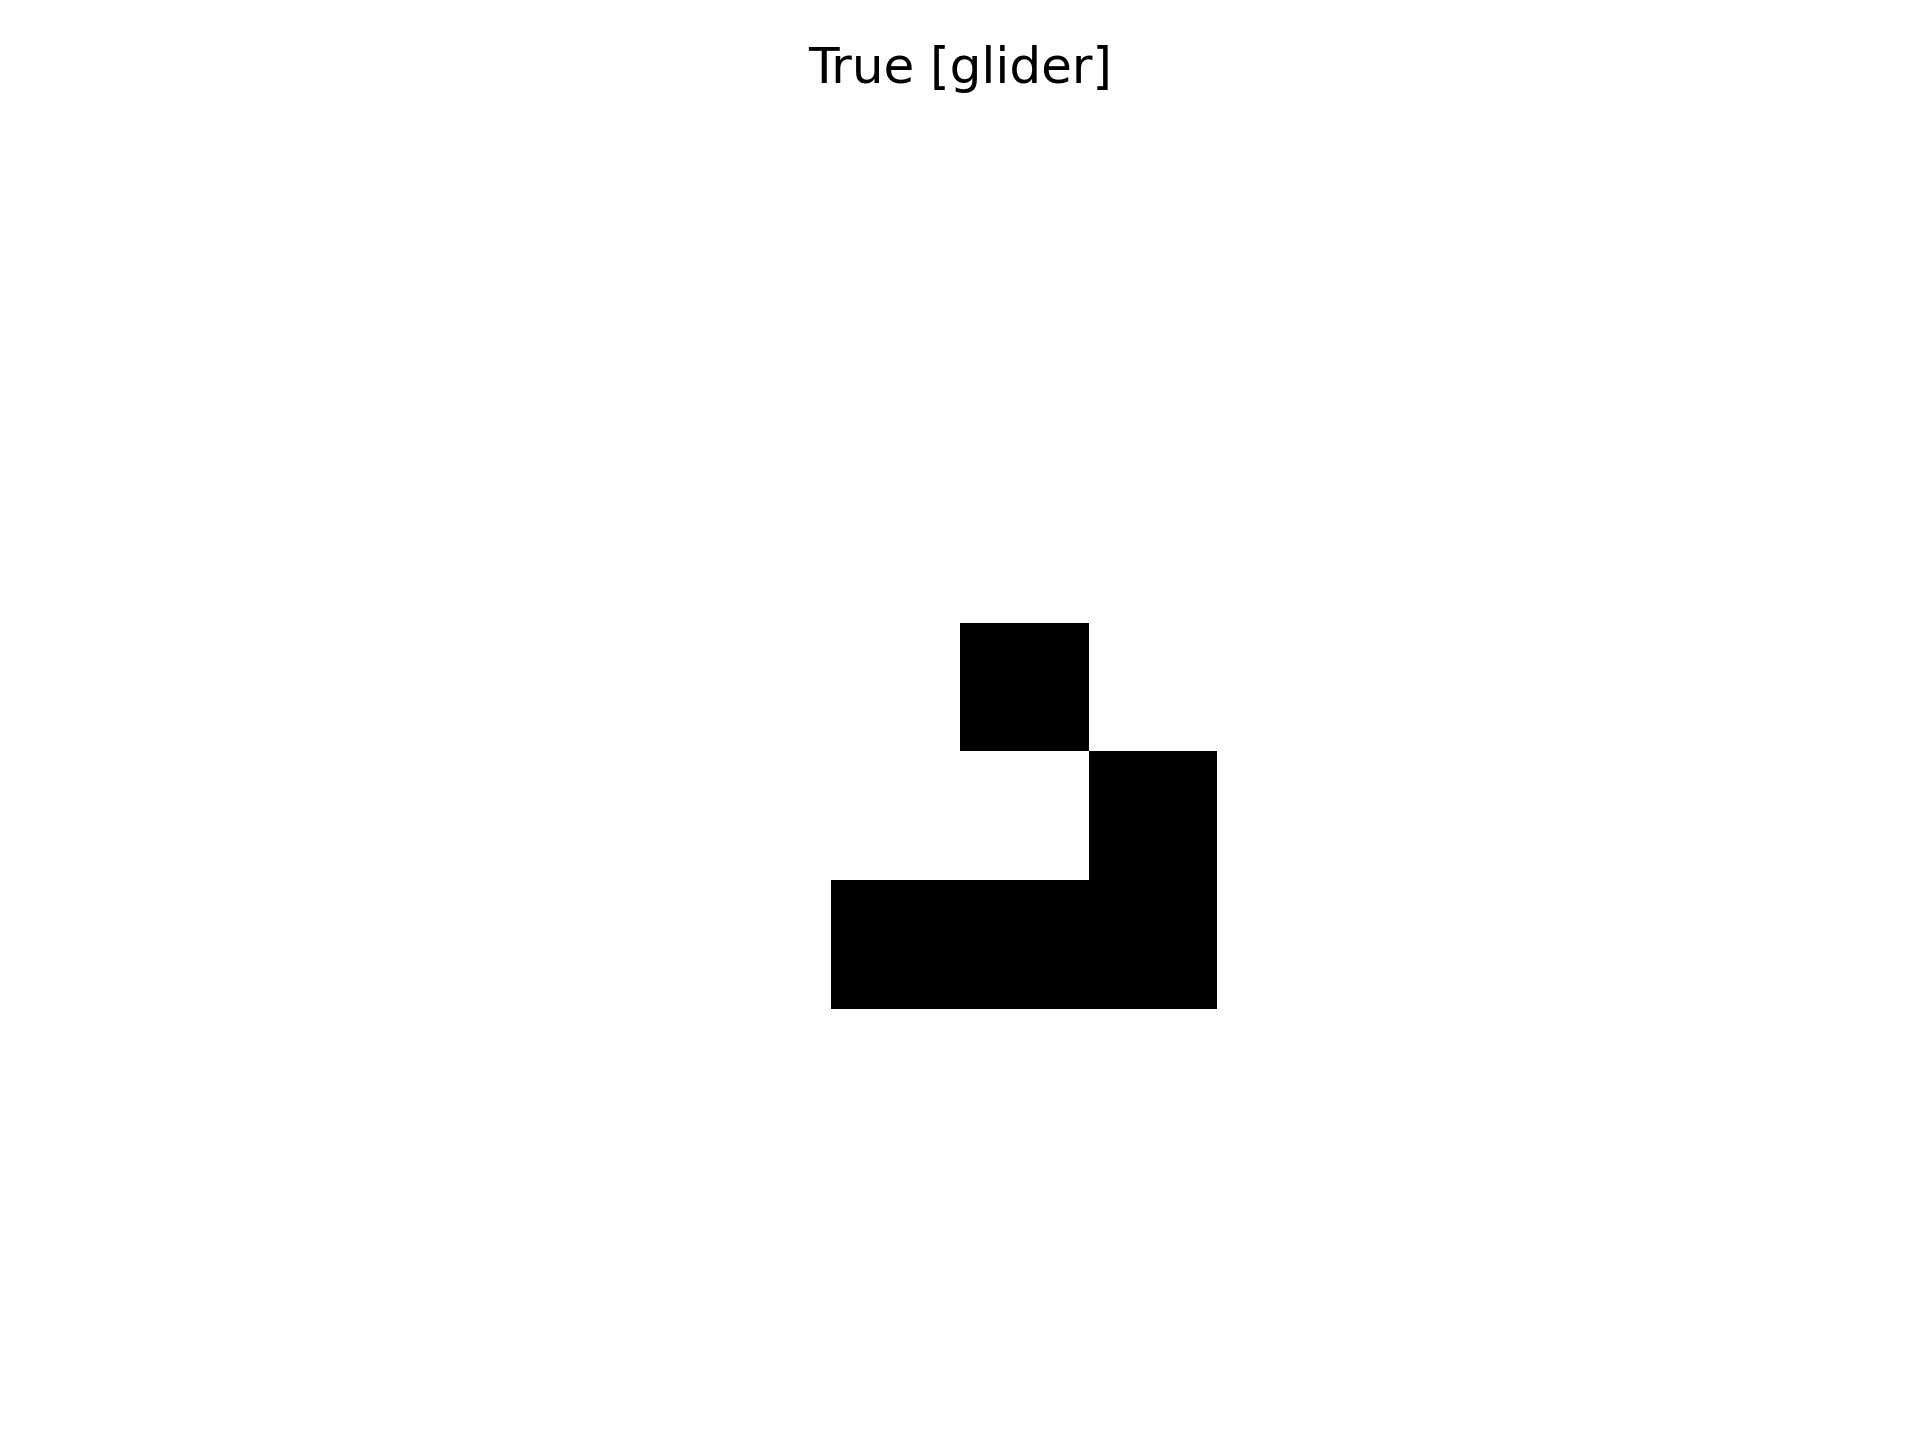

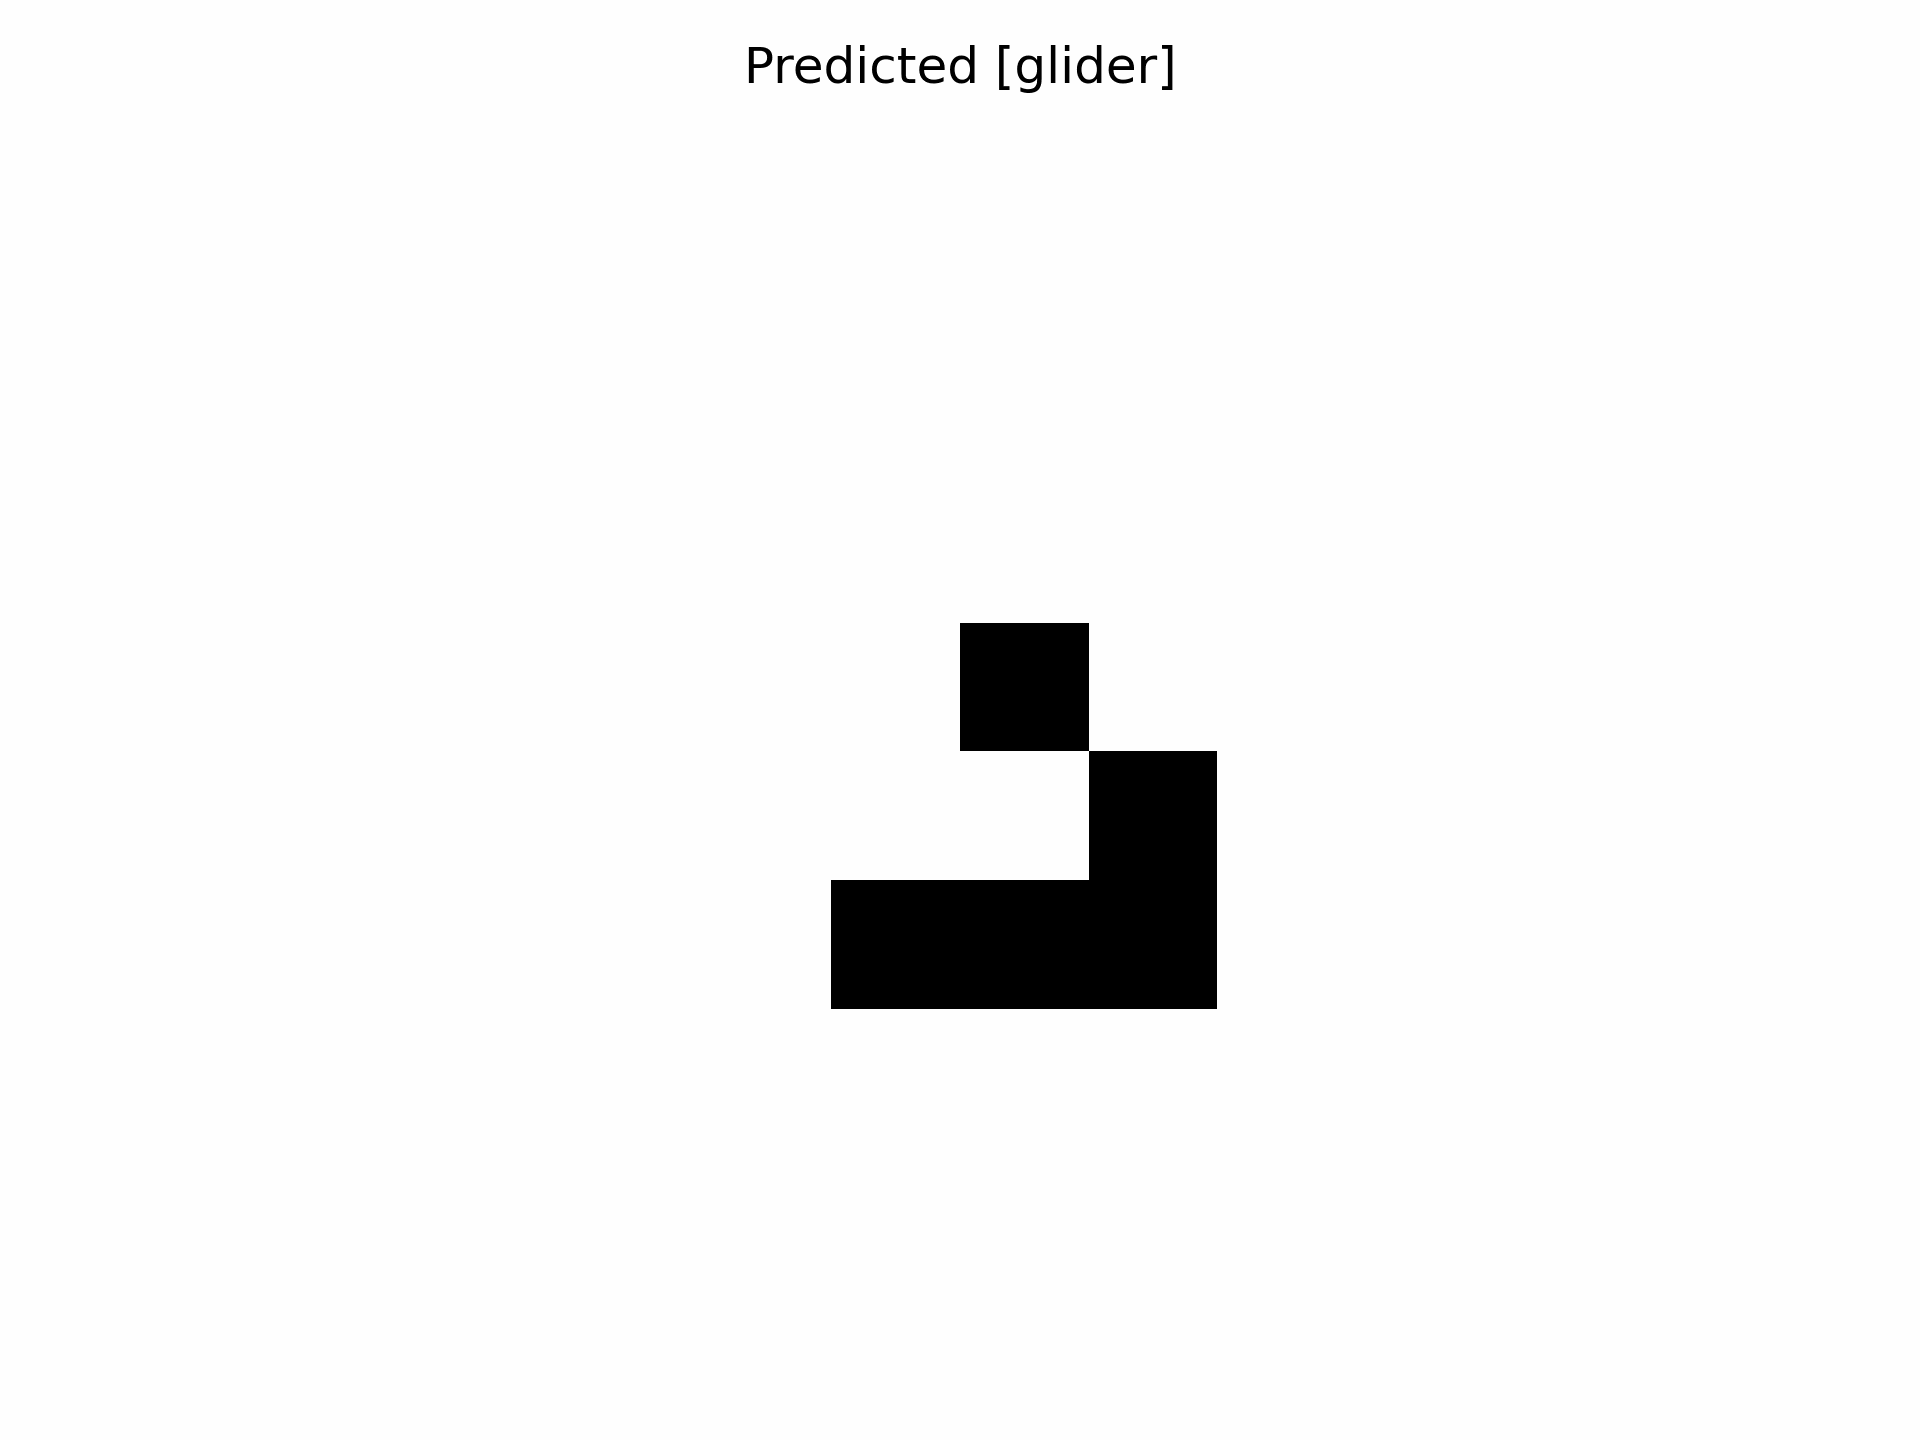

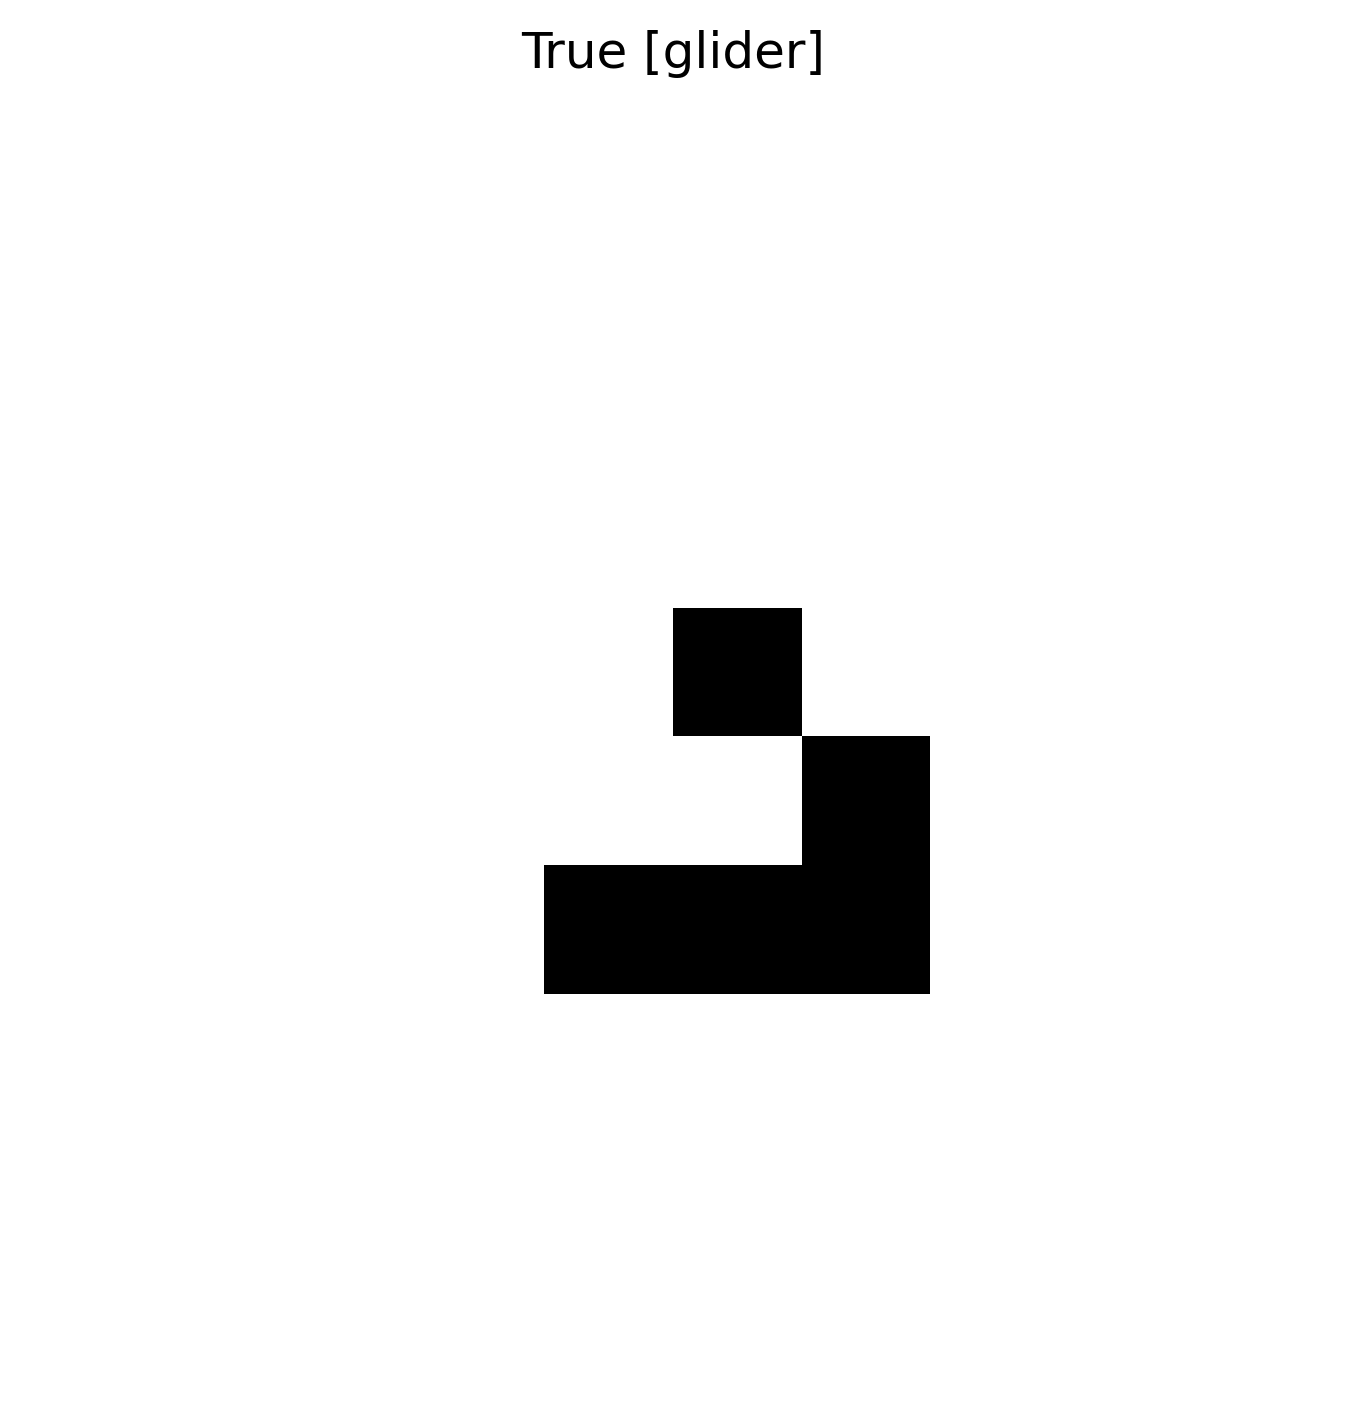

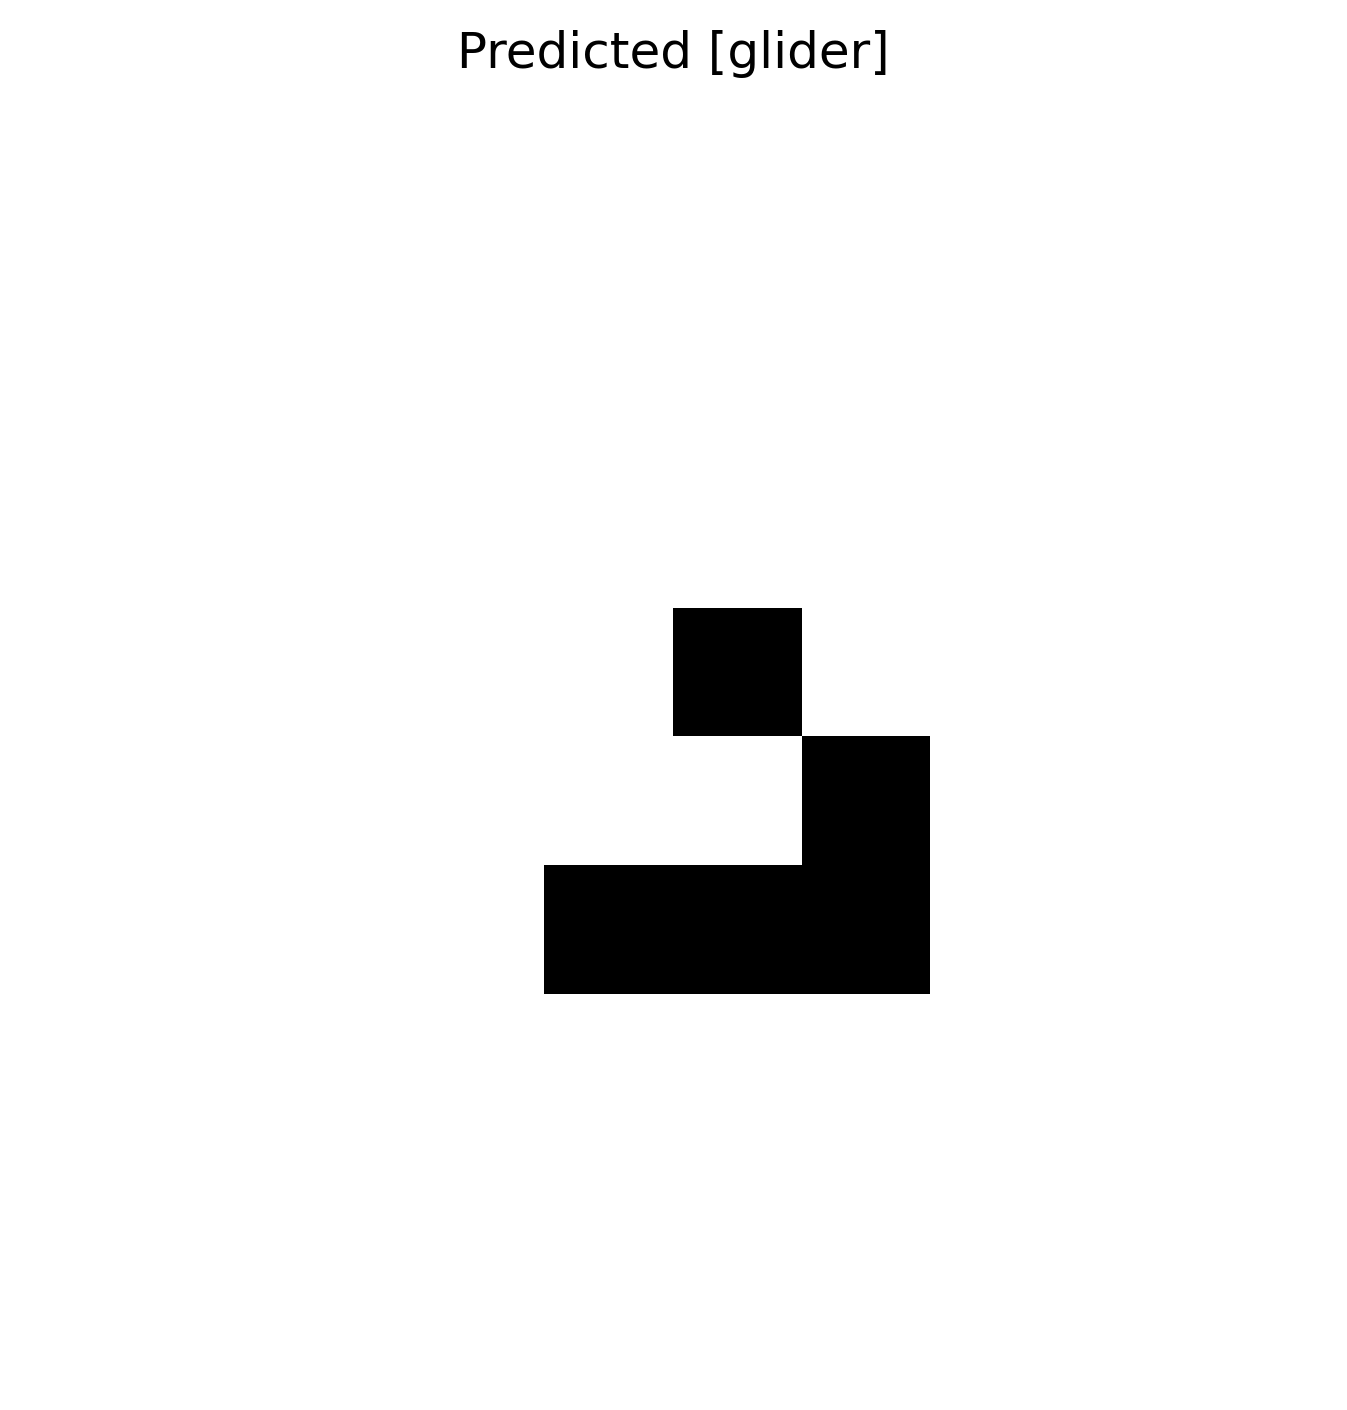

In [9]:
STEPS = 40

init_state = make_glider(dims0=BOARD_SIZE)[None, ...]
true_states = play_game(init_state, STEPS)
pred_states = play_game_with_model(init_state, model, STEPS)
    
plot_states(true_states, 'True [glider]', 'images/gol_true.gif')
plot_states(pred_states, 'Predicted [glider]', 'images/gol_pred.gif')

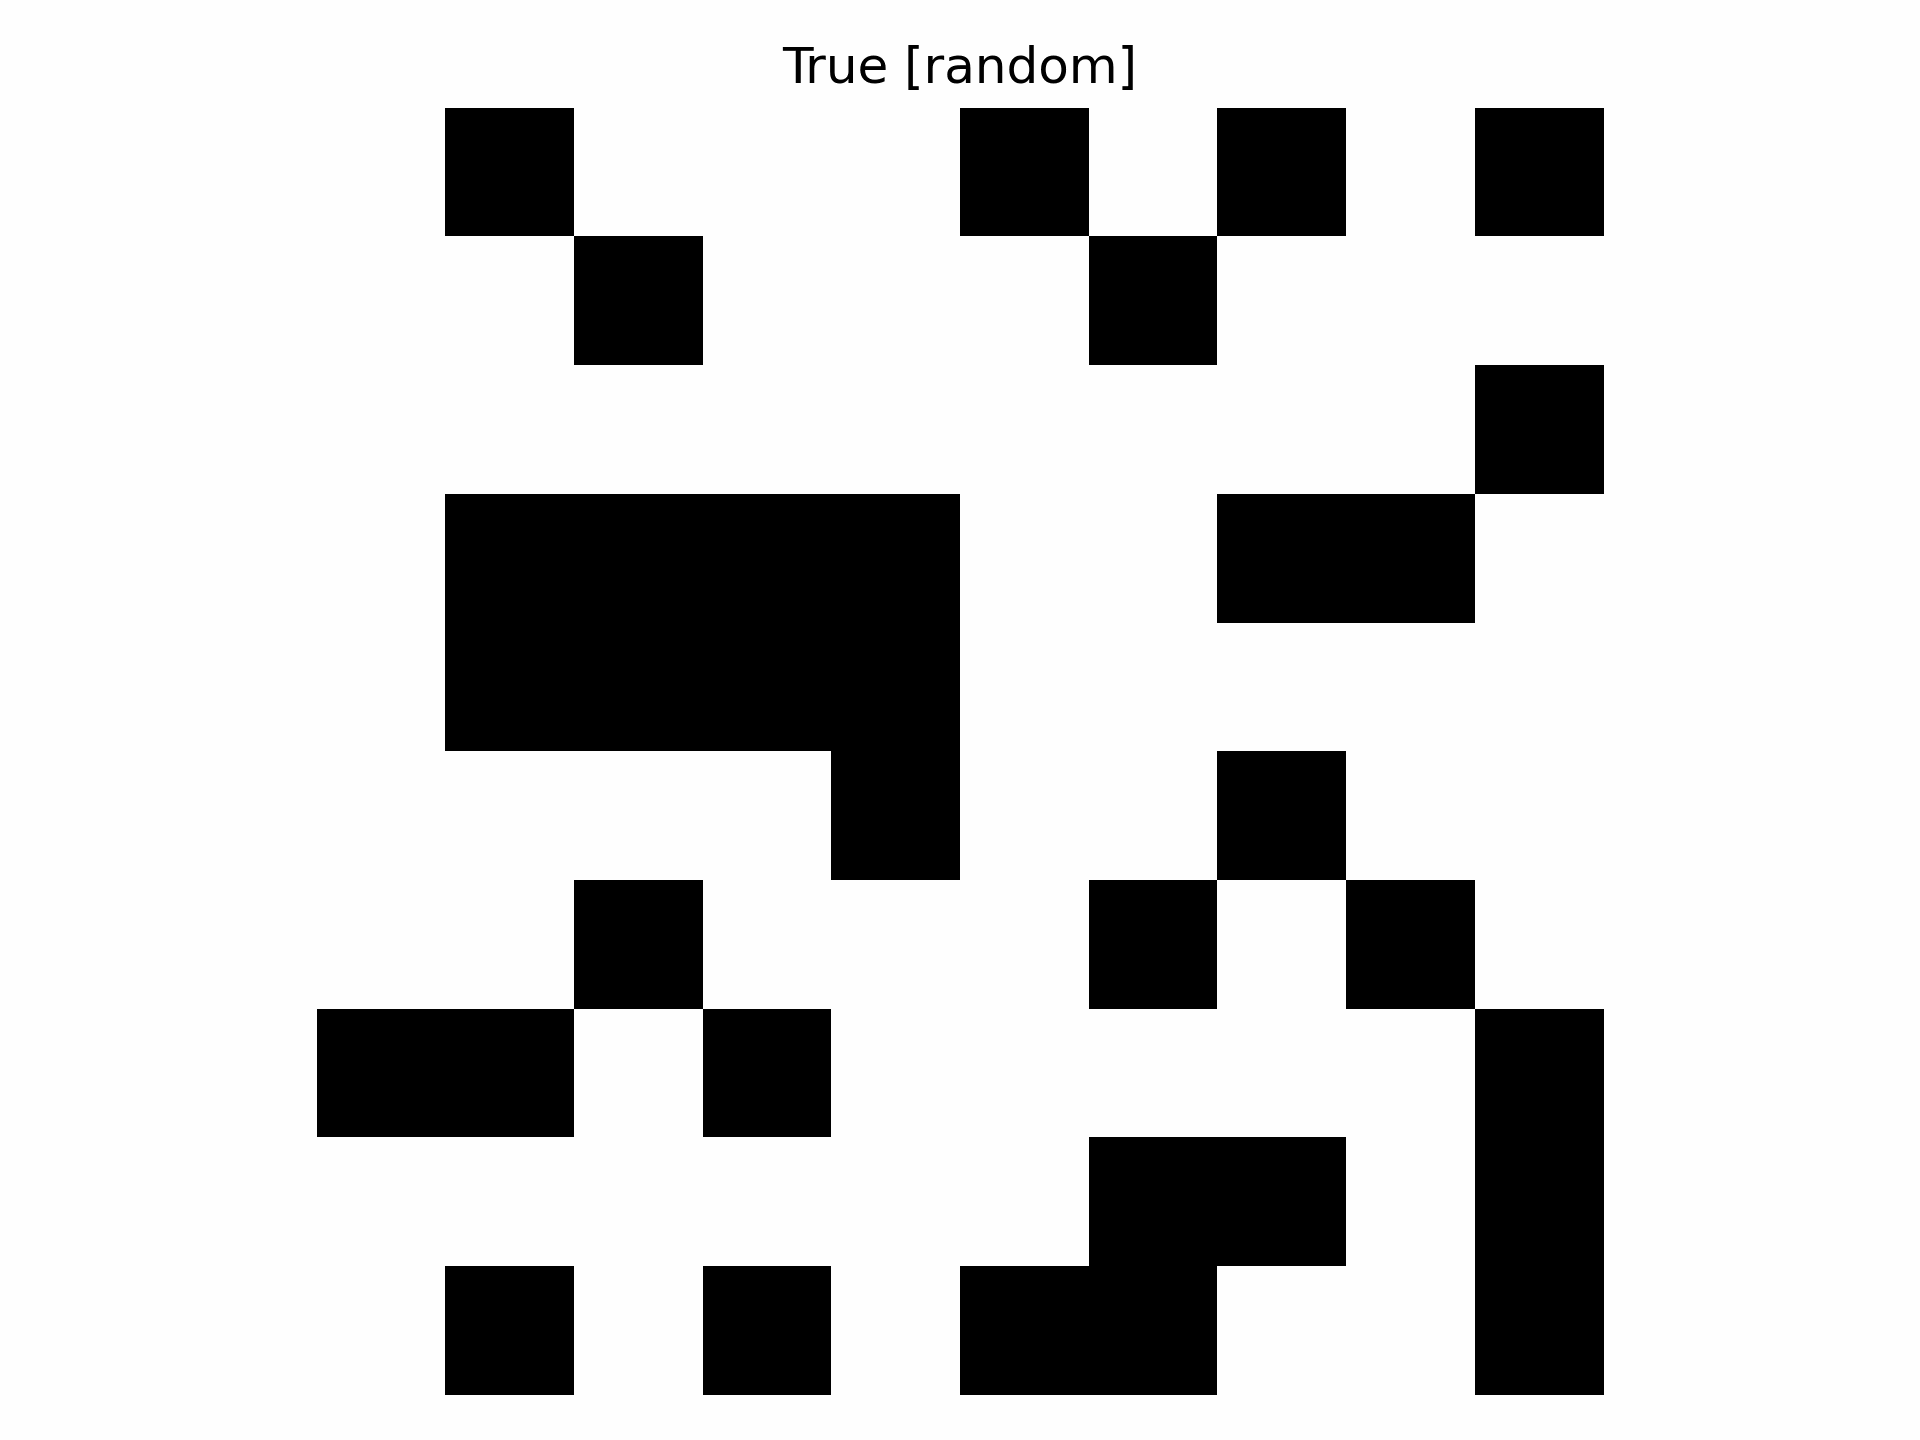

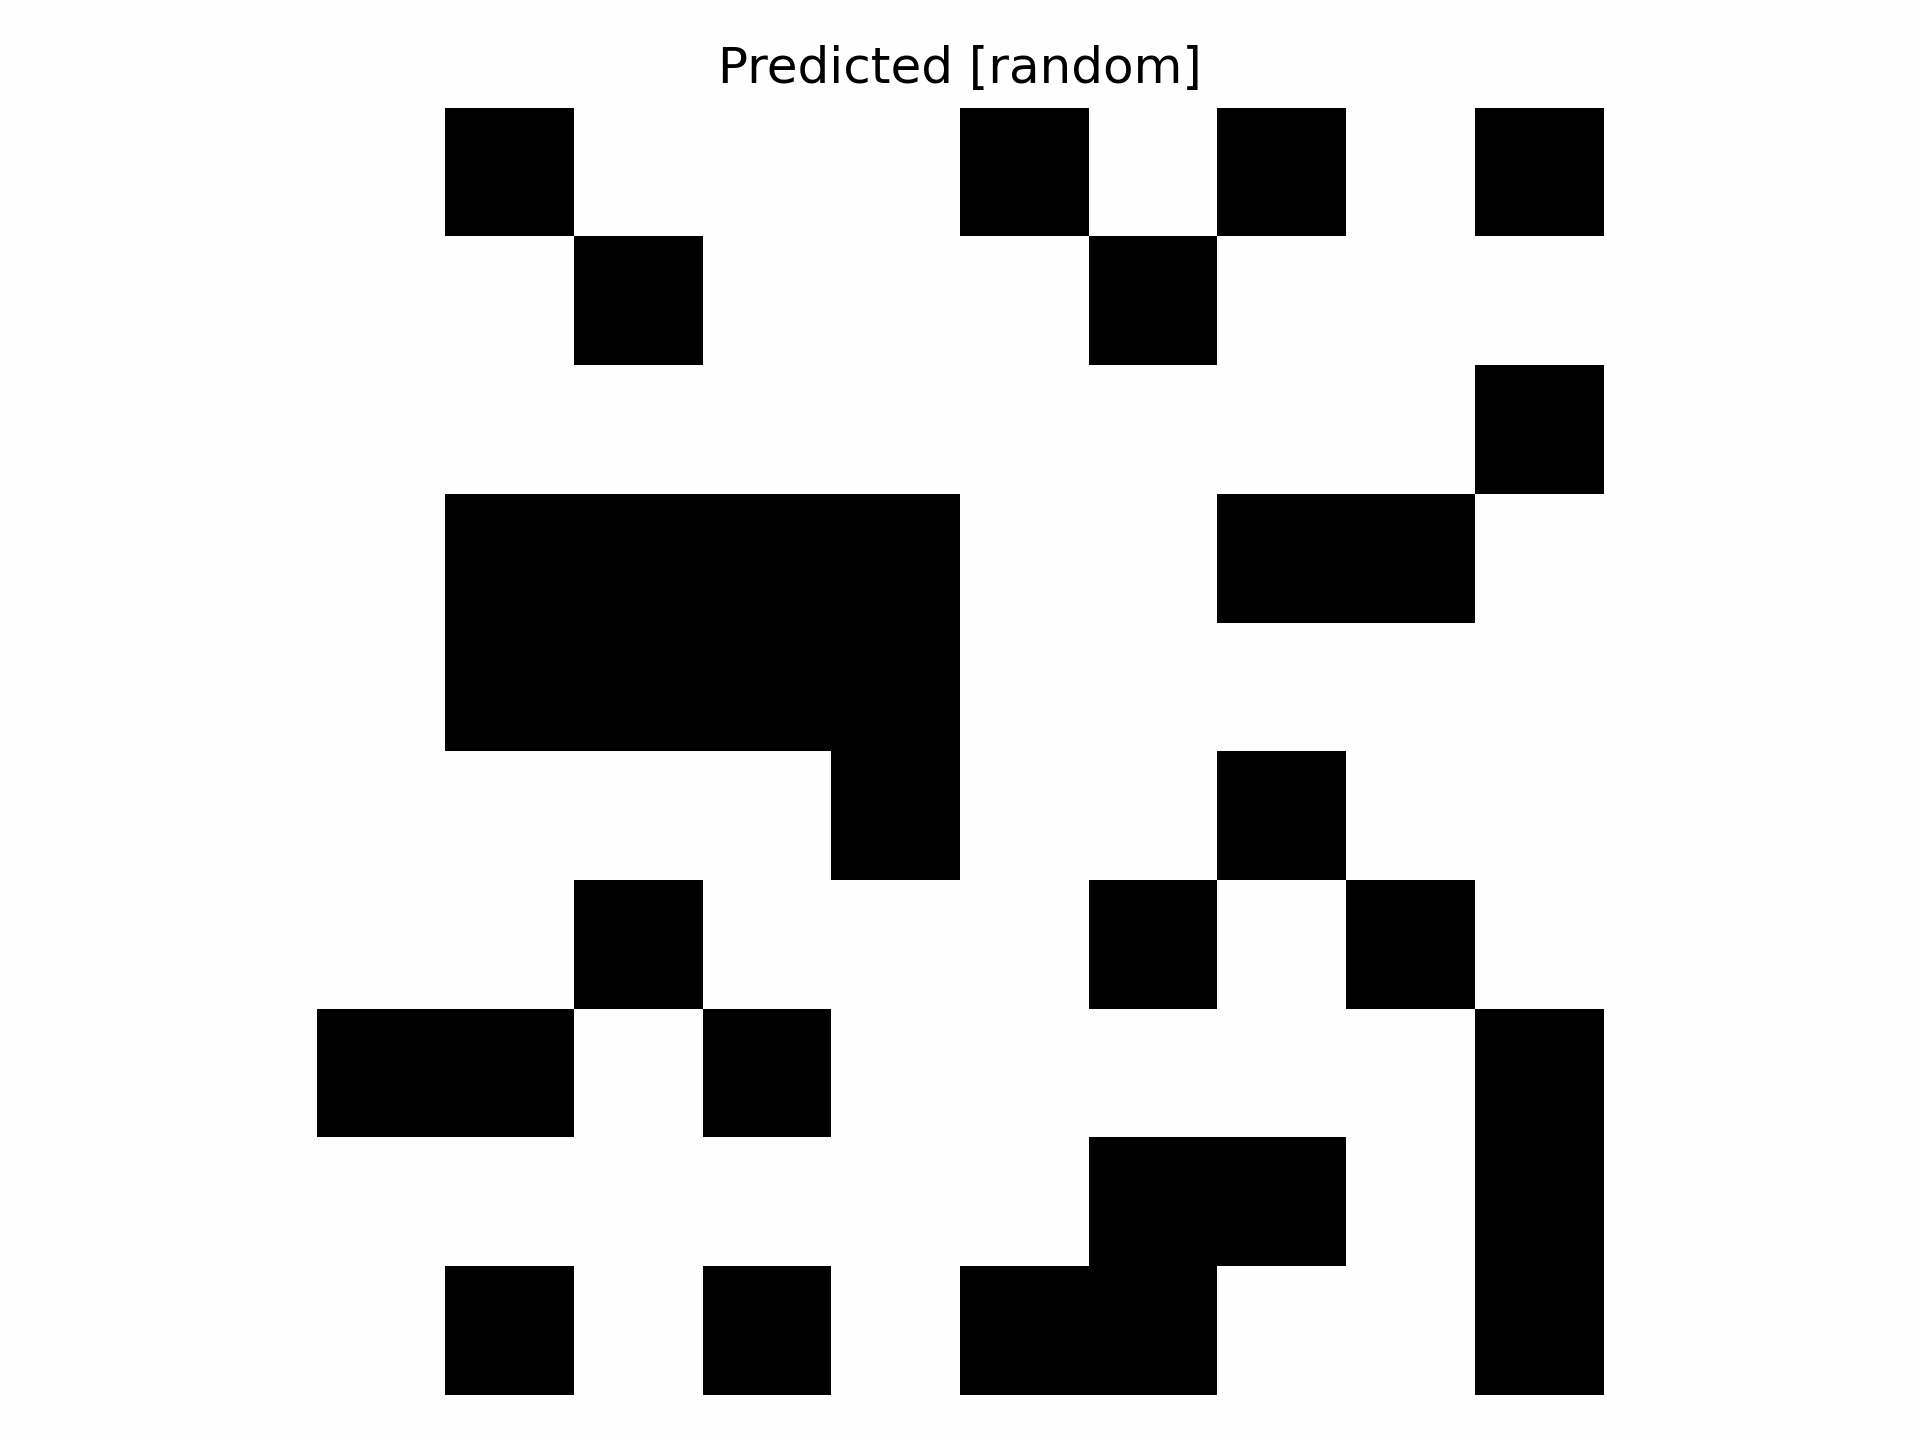

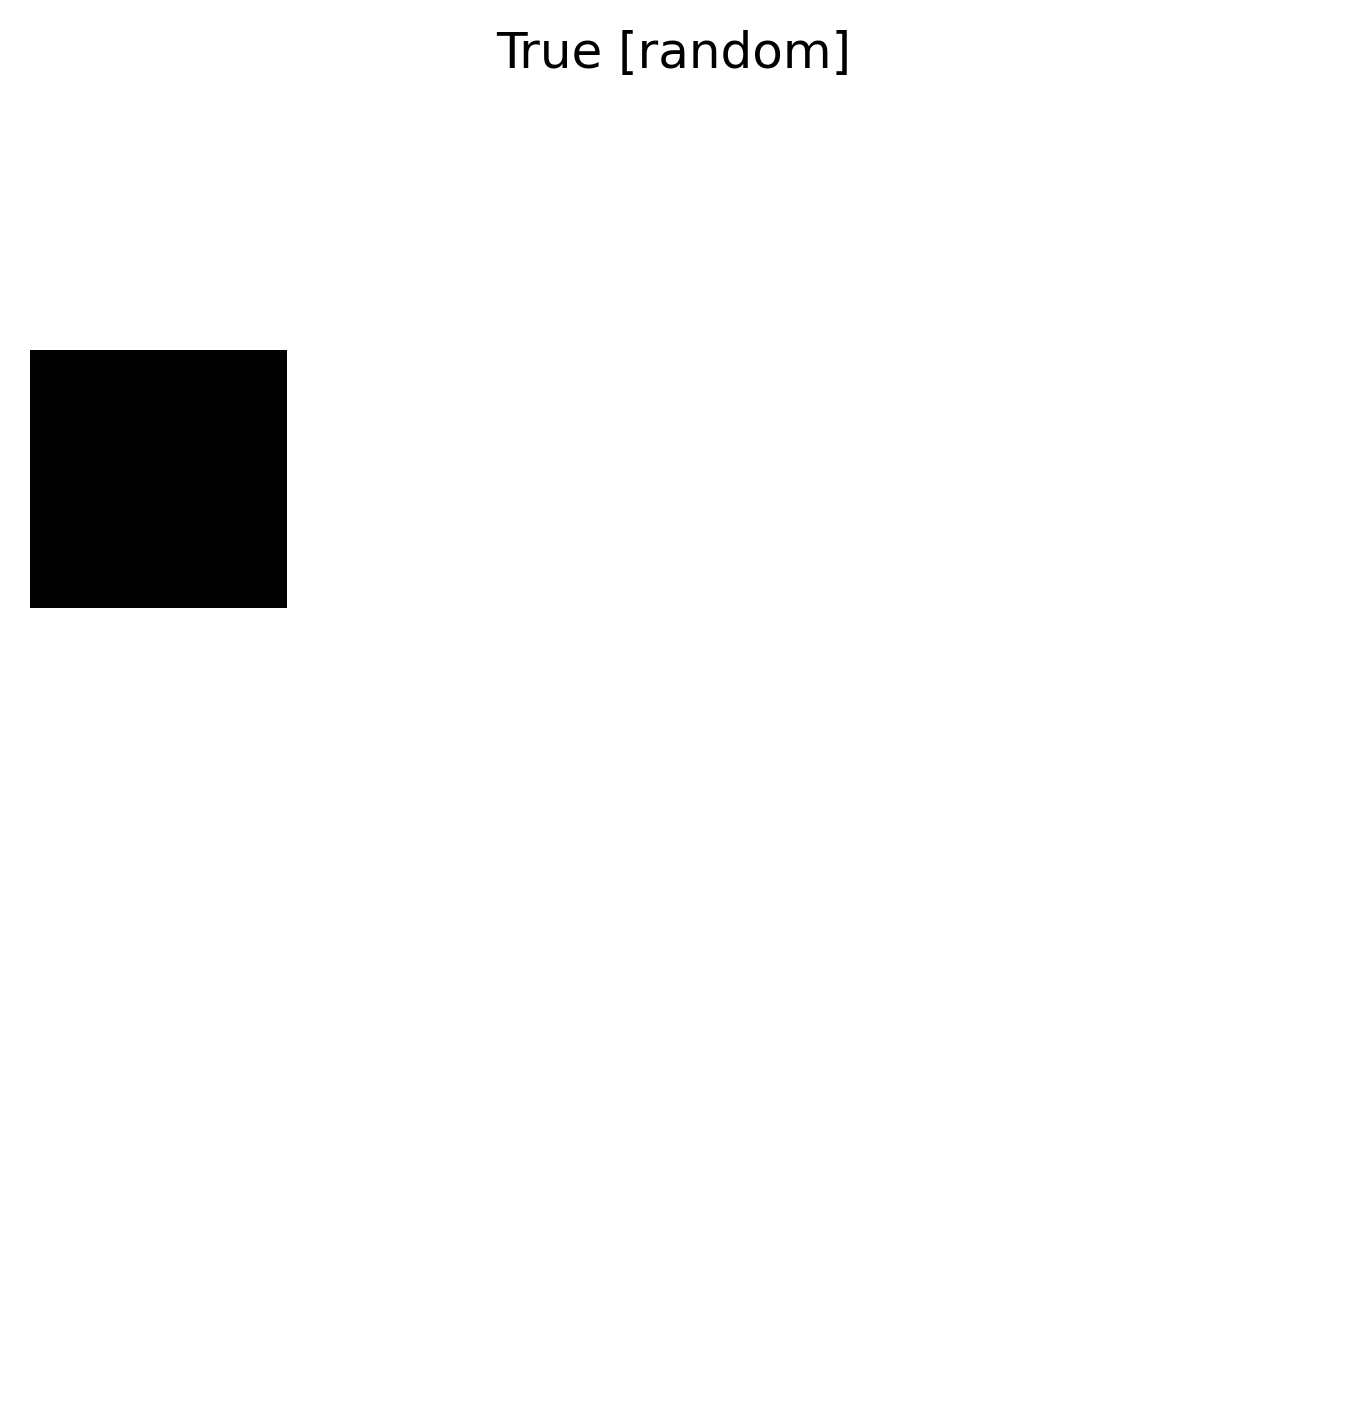

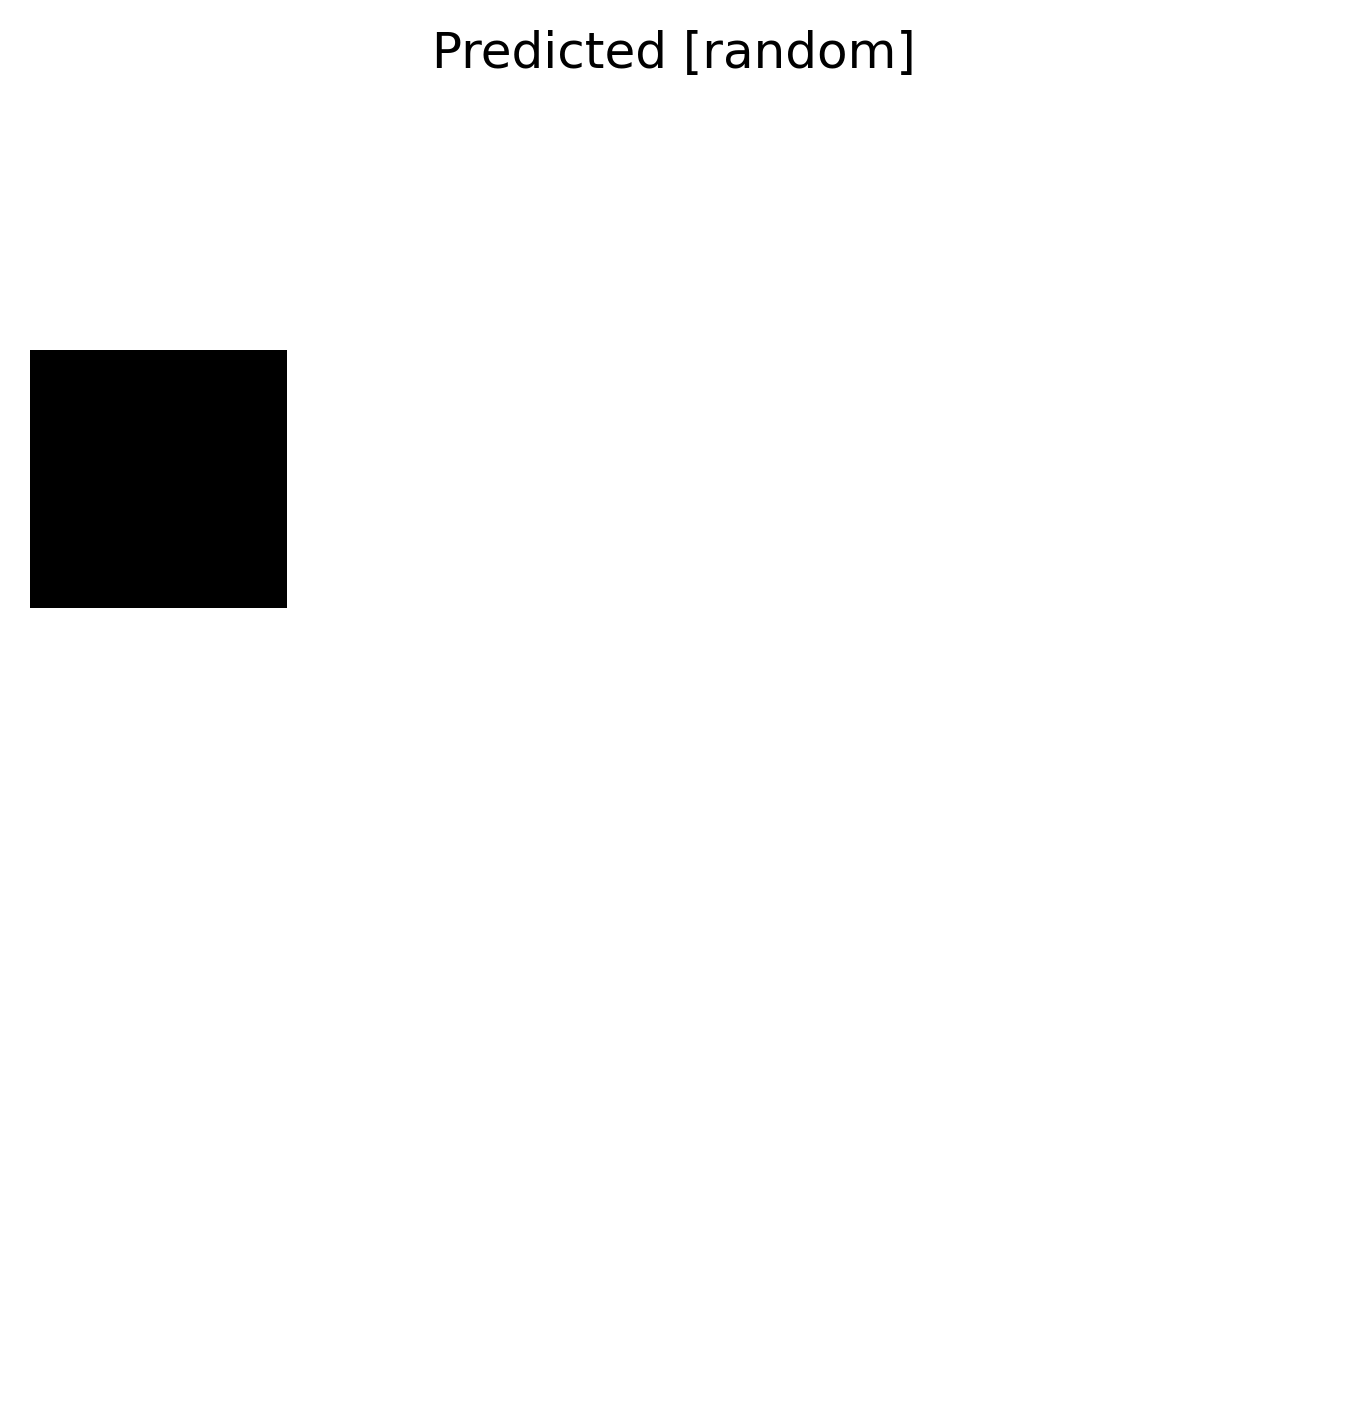

In [10]:
STEPS = 100

init_state = tf.random.categorical(tf.math.log([[0.7, 0.3]]), BOARD_SIZE * BOARD_SIZE)
init_state = tf.cast(init_state, tf.float32)
init_state = tf.reshape(init_state, (1, BOARD_SIZE, BOARD_SIZE))

true_states = play_game(init_state, STEPS)
pred_states = play_game_with_model(init_state, model, STEPS)
    
plot_states(true_states, 'True [random]', 'images/random_true.gif')
plot_states(pred_states, 'Predicted [random]', 'images/random_pred.gif')

### Activation of hidden layers

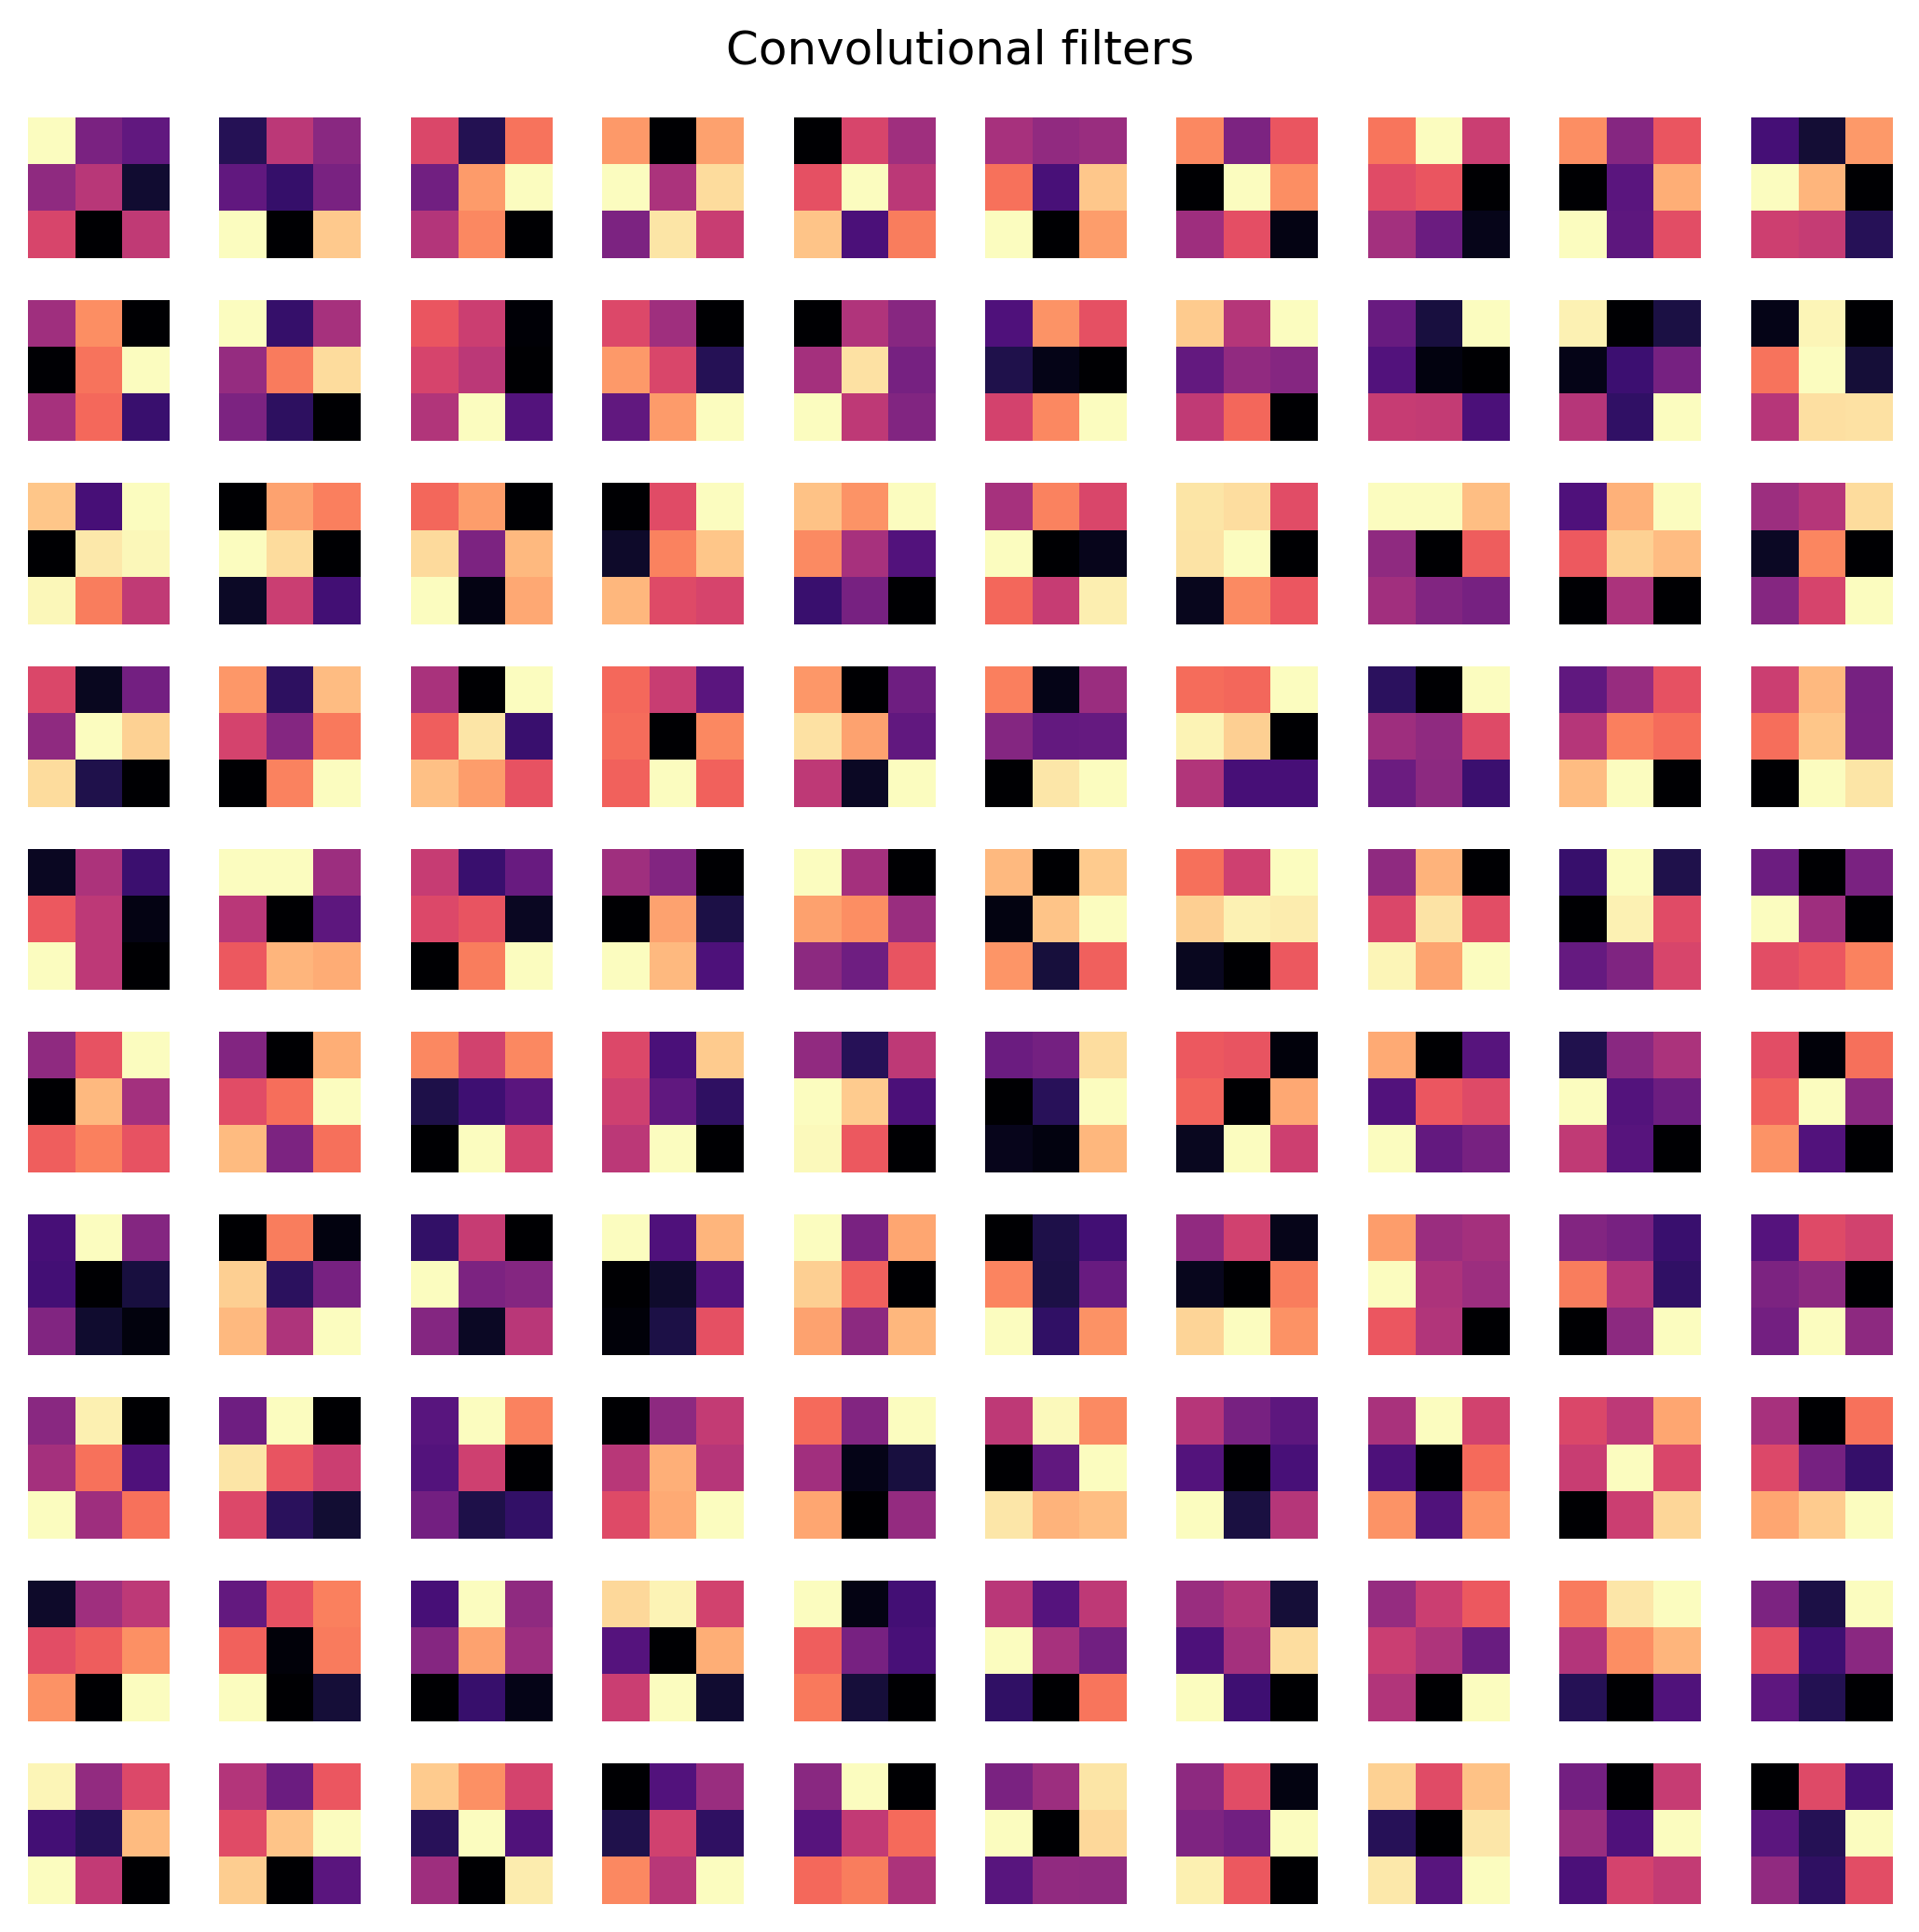

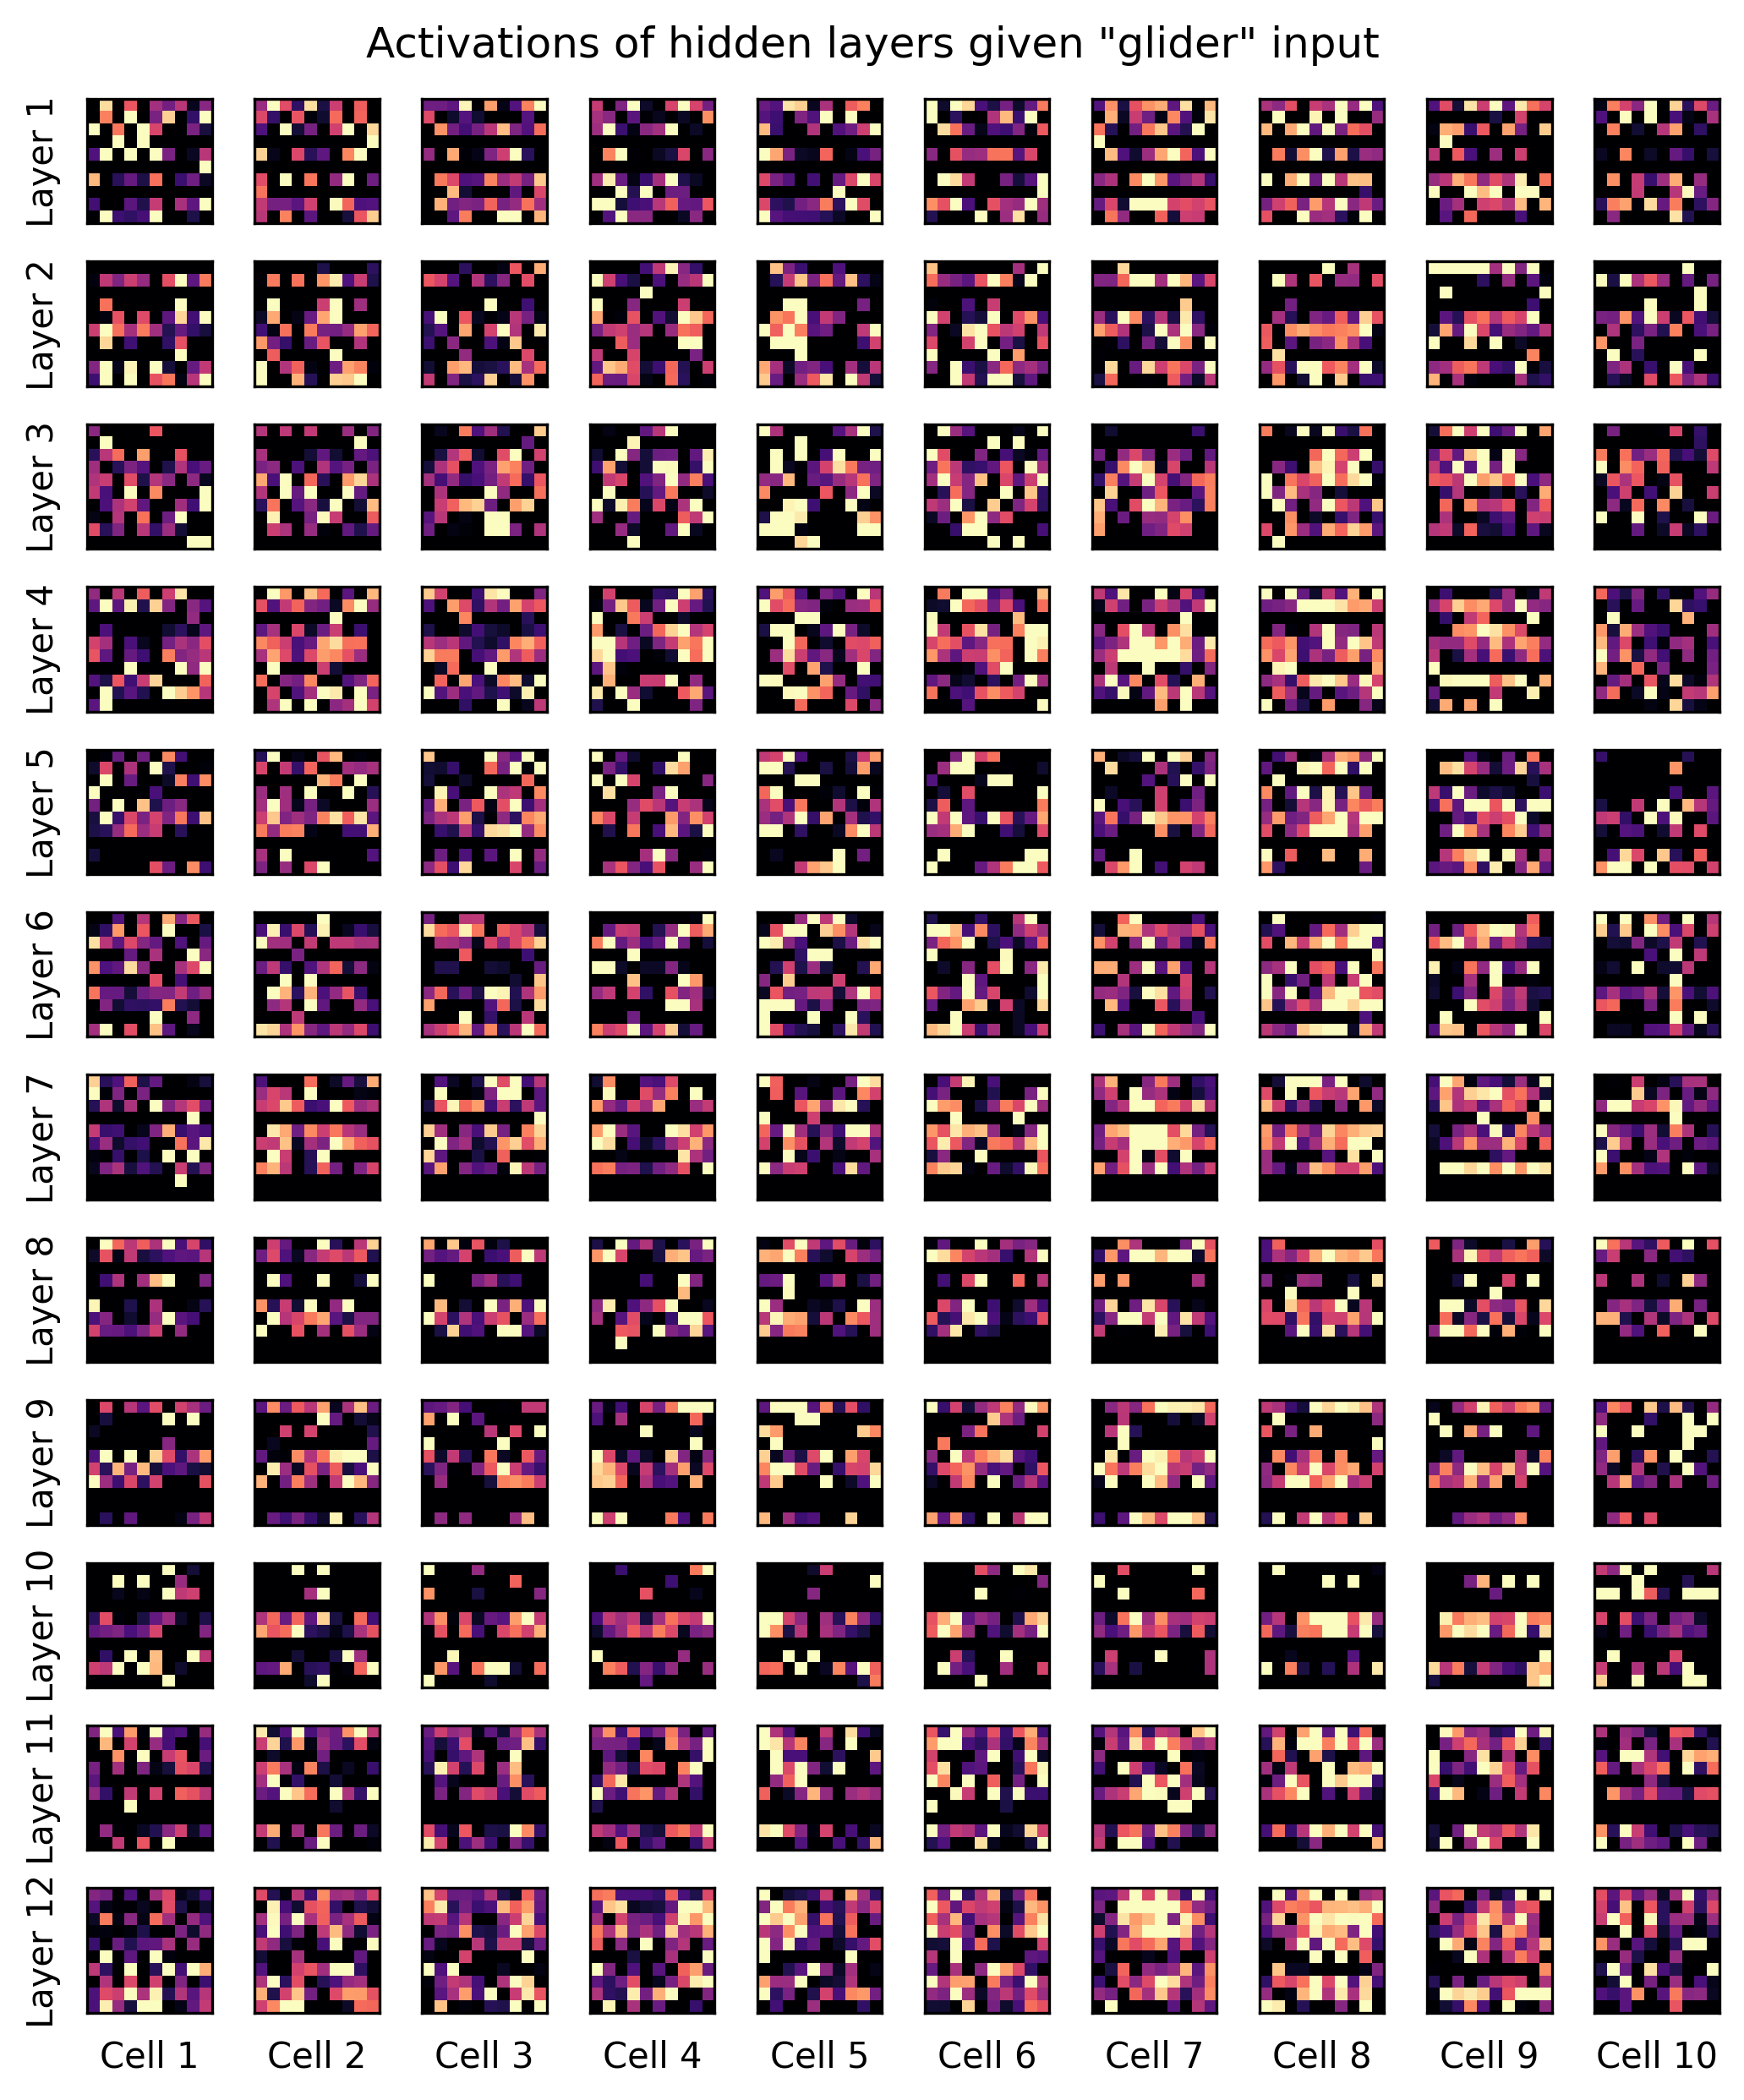

In [11]:
outputs = [layer.output for layer in model.layers]
functor = K.function(model.input, outputs)
layer_outs = functor([X_train[0][None, ...]])

_, axes = plt.subplots(10, 10, figsize=(7, 7))

for i in range(10):
    for j in range(10):
        axes[i, j].imshow(model.layers[1].weights[0].numpy()[..., 0, i * 10 + j], cmap='magma')
        axes[i, j].axis('off')

plt.suptitle("Convolutional filters")
plt.tight_layout()
plt.show()

all_layer_activations = []

for j in range(2, len(outputs) - 2):
    if j == 1:
        layer_im = np.hstack([MinMaxScaler().fit_transform(layer_outs[j][0][..., i]) for i in range(BOARD_SIZE)])
    else:
        pattern = np.reshape(layer_outs[j][0], (BOARD_SIZE, BOARD_SIZE, -1))
        layer_im = np.hstack([MinMaxScaler().fit_transform(pattern[..., i]) for i in range(BOARD_SIZE)])

    all_layer_activations.append(layer_im)

n, m = len(all_layer_activations), len(all_layer_activations[0])
_, axes = plt.subplots(n, m, figsize=(m * 0.7, n * 0.7))

for i, layer in enumerate(all_layer_activations):
    for j, activation in enumerate(layer):
        axes[i, j].imshow(activation.reshape(BOARD_SIZE, BOARD_SIZE), cmap='magma')
        axes[i, j].tick_params(axis='both', which='both', length=0)
        axes[i, j].set_xticklabels([])
        axes[i, j].set_yticklabels([])
        axes[i, 0].set_ylabel(f'Layer {i + 1}')
        axes[-1, j].set_xlabel(f'Cell {j + 1}')

plt.suptitle("Activations of hidden layers given \"glider\" input")
plt.tight_layout()
plt.show()

### Dependence of training results on rule entropy

"Training 2560 convolutional neural networks on random cellular automata. (a) A network trained on the Game of Life for different durations, and then applied to images of each stage of the “glider” solution. (b) The loss versus time during training, colored by the rule entropy $H_{ca}$."

![Training](images/training.png)